In [31]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import ndcg_score

# 1. Load and Inspect Dataset

In [32]:
df = pd.read_csv("COVID19_sample.csv", parse_dates=['created_at'])
df.head()

,Unnamed: 0,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
0,0,1340468299025551360,2020-12-20 01:25:21+00:00,497188910,1340325850378592257,1017807360075665408,64.5
1,5,1340480189462134784,2020-12-20 02:12:36+00:00,2288557992,1340427316573462530,1063806444380798976,95.0
2,6,1340481082270085120,2020-12-20 02:16:09+00:00,1237071348662448129,1340427316573462530,1063806444380798976,95.0
3,7,1340481539709276163,2020-12-20 02:17:58+00:00,475234937,1340481328056332289,122733775,90.0
4,9,1340489259183206406,2020-12-20 02:48:39+00:00,100878763,1340427316573462530,1063806444380798976,95.0


# 2. Filter for Misinformation

In [33]:
misinfo_df = df[df['credibility_score'] <= 39].copy()
misinfo_df = misinfo_df[misinfo_df['user_id'] != misinfo_df['retweeted_user_id']]
display(misinfo_df.head())
print(f"Misinformation records: {len(misinfo_df)}")

,Unnamed: 0,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
8,17,1340503740433002496,2020-12-20 03:46:11+00:00,1277804951842979845,1340503265373466624,242880993,20.0
11,21,1340515040370278402,2020-12-20 04:31:05+00:00,1102714987787837445,1340503265373466624,242880993,20.0
13,24,1340519044961759232,2020-12-20 04:47:00+00:00,988373714,1340428826694852609,372937945,5.0
15,27,1340521034517241857,2020-12-20 04:54:54+00:00,140032760,1340324106487656449,726721856749842436,5.0
16,28,1340521296531218438,2020-12-20 04:55:57+00:00,69920939,1340503265373466624,242880993,20.0


Misinformation records: 5288


# 3. Compute Influential Metric

In [34]:
# Count how many times each post was retweeted
repost_counts = misinfo_df.groupby('retweeted_status_id').size().rename('repost_count')

# Join repost counts back to misinfo data
misinfo_df = misinfo_df.merge(repost_counts, left_on='retweeted_status_id', right_index=True)

# Compute Influential score per user (original authors of misinfo)
influential_scores = misinfo_df.groupby('retweeted_user_id')['repost_count'].sum().rename('influential_score')
influential_ranking = influential_scores.sort_values(ascending=False)
influential_ranking.head()

retweeted_user_id
962681176526852096     70225
1108513736250310657    45369
1683455144             36355
3327831430             23429
1063806444380798976    21096
Name: influential_score, dtype: int64

# 4. Optional: Temporal EMA Smoothing (EMA)

In [ ]:
start_date = df['created_at'].min()
end_date = df['created_at'].max()
delta = timedelta(days=3)
alpha = 0.5

# Create time windows
time_slots = []
current = start_date
while current < end_date:
    time_slots.append((current, current + delta))
    current += delta

# Compute influential score for each user per time slot
temporal_scores = {}
for start, end in time_slots:
    window_df = misinfo_df[(misinfo_df['created_at'].dt.date >= start) & (misinfo_df['created_at'].dt.date < end)]
    scores = window_df.groupby('retweeted_user_id').size()
    for user, score in scores.items():
        if user not in temporal_scores:
            temporal_scores[user] = []
        temporal_scores[user].append(score)

# Apply EMA per user
temporal_ema = {}
for user, scores in temporal_scores.items():
    ema = scores[0]
    for score in scores[1:]:
        ema = alpha * ema + (1 - alpha) * score
    temporal_ema[user] = ema

temporal_ranking = pd.Series(temporal_ema).sort_values(ascending=False)
temporal_ranking

KeyError: 'date'

# 5. Build Re-share Network (for misinformation only)


In [ ]:
G = nx.DiGraph()
for _, row in misinfo_df.iterrows():
    source = row['retweeted_user_id']  # original author
    target = row['user_id']  # retweeter
    if G.has_edge(source, target):
        G[source][target]['weight'] += 1
    else:
        G.add_edge(source, target, weight=1)

# Total misinformation volume
total_misinfo_volume = sum([d['weight'] for _, _, d in G.edges(data=True)])

# 6. Network Dismantling and Evaluation Metrics

In [ ]:
def network_dismantling(G, ranking, k_values):
    removed_misinfo = []
    remaining_graph = G.copy()
    for k in k_values:
        top_users = ranking.head(k).index
        G_k = remaining_graph.copy()
        for user in top_users:
            if user in G_k:
                G_k.remove_node(user)
        removed_volume = total_misinfo_volume - sum([d['weight'] for _, _, d in G_k.edges(data=True)])
        removed_misinfo.append(removed_volume / total_misinfo_volume)
    return removed_misinfo

k_values = [5, 10, 20, 50]
quality_scores = network_dismantling(G, temporal_ranking, k_values)

# Ground-truth ranking (baseline): by actual volume in test set
true_spread = misinfo_df.groupby('retweeted_user_id')['repost_count'].sum()
true_ranking = true_spread.sort_values(ascending=False)
baseline_scores = network_dismantling(G, true_ranking, k_values)

# Compute nDCG@K
predicted_relevance = temporal_ranking.reindex(true_ranking.index).fillna(0).values.reshape(1, -1)
true_relevance = true_ranking.values.reshape(1, -1)
nDCG_at_k = []
for k in k_values:
    if k > 1:
        nDCG_at_k.append(ndcg_score(true_relevance[:, :k], predicted_relevance[:, :k]))
    else:
        nDCG_at_k.append(np.nan)  # or None

# 7. Plot and Compare Results

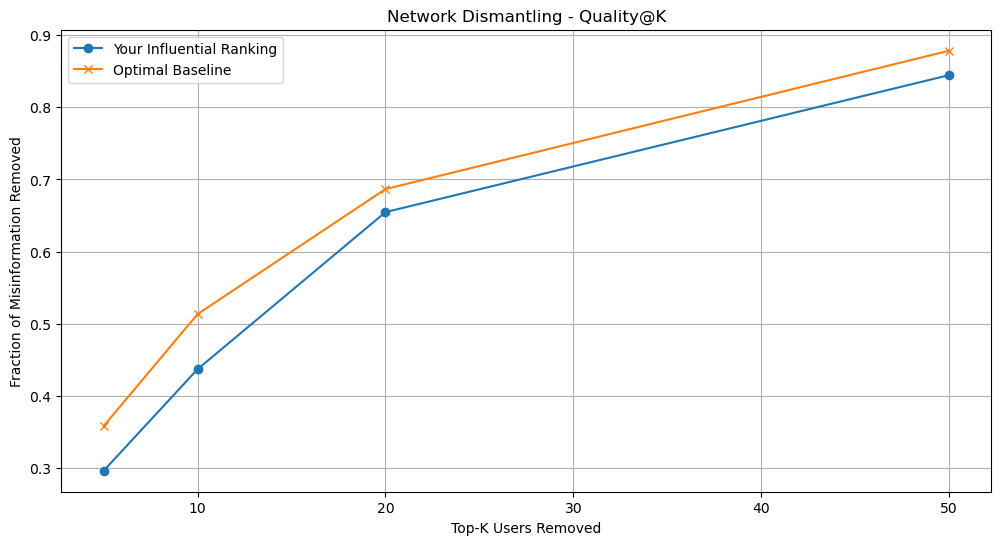

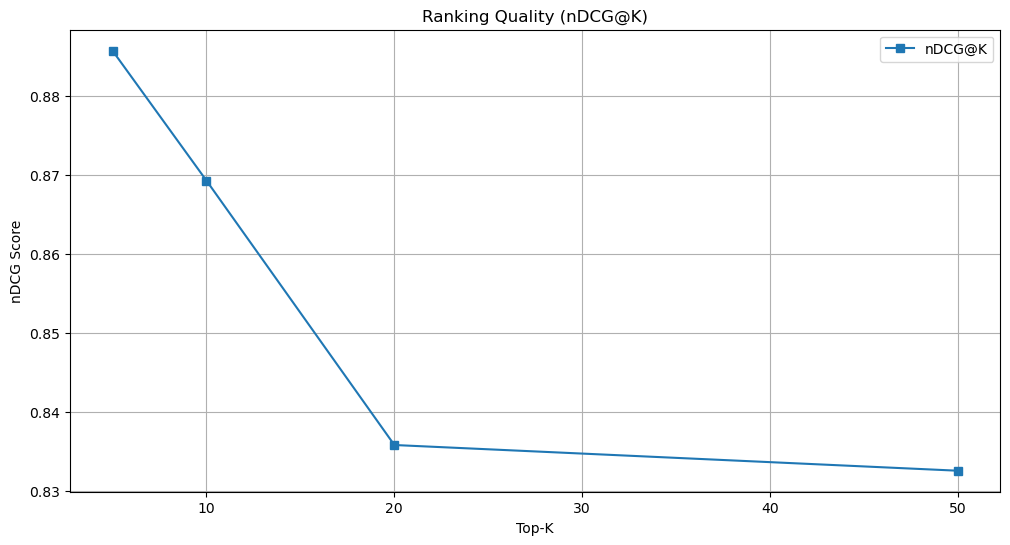

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(k_values, quality_scores, label='Your Influential Ranking', marker='o')
plt.plot(k_values, baseline_scores, label='Optimal Baseline', marker='x')
plt.xlabel('Top-K Users Removed')
plt.ylabel('Fraction of Misinformation Removed')
plt.title('Network Dismantling - Quality@K')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(k_values, nDCG_at_k, label='nDCG@K', marker='s')
plt.xlabel('Top-K')
plt.ylabel('nDCG Score')
plt.title('Ranking Quality (nDCG@K)')
plt.grid(True)
plt.legend()
plt.show()